**Transformers Fine Tuning**

In [ ]:
!pip install evaluate rouge_score

In [ ]:
!pip install transformers[torch] accelerate -U


In [ ]:
import pandas as pd
import numpy as np
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import textwrap
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from datasets import load_dataset
df = load_dataset('cnn_dailymail', '3.0.0')



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [ ]:
df_train = pd.DataFrame(df['train'])
df_test = pd.DataFrame(df['test'])
df_val = pd.DataFrame(df['validation'])

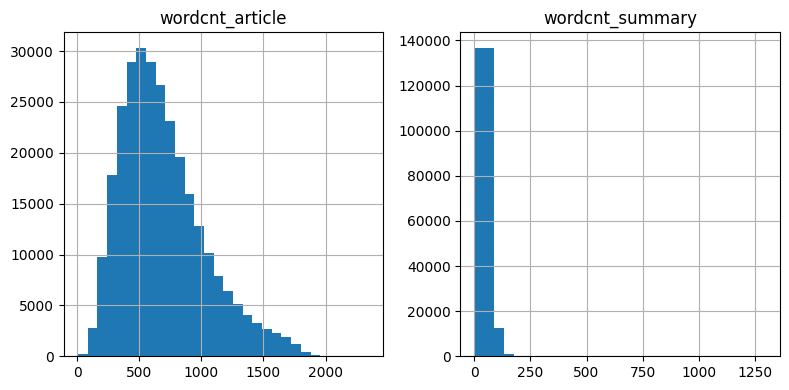

In [ ]:
def count_words(text):
    return len(text.split())
train_df = pd.DataFrame(df['train'])
train_df['wordcnt_article'] = train_df['article'].apply(count_words)
train_df['wordcnt_summary'] = train_df['highlights'].apply(count_words)
train_df.head()

numerical_columns = train_df.select_dtypes(include=['int64'])

# Create histograms for all numerical columns
numerical_columns.hist(bins=30, figsize=(8, 4))  # Adjust 'bins' and 'figsize' as needed
plt.tight_layout()  # Ensure proper spacing between plots

plt.show()

In [ ]:
# Define function to wrap text
def wrap(x):
    return textwrap.fill(x,replace_whitespace=False,fix_sentence_endings=True)

print(wrap(df_train['article'][1]))

Editor's note: In our Behind the Scenes series, CNN correspondents
share their experiences in covering news and analyze the stories
behind the events.  Here, Soledad O'Brien takes users inside a jail
where many of the inmates are mentally ill.  An inmate housed on the
"forgotten floor," where many mentally ill inmates are housed in Miami
before trial.  MIAMI, Florida (CNN) -- The ninth floor of the Miami-
Dade pretrial detention facility is dubbed the "forgotten floor."
Here, inmates with the most severe mental illnesses are incarcerated
until they're ready to appear in court.  Most often, they face drug
charges or charges of assaulting an officer --charges that Judge
Steven Leifman says are usually "avoidable felonies."  He says the
arrests often result from confrontations with police.  Mentally ill
people often won't do what they're told when police arrive on the
scene -- confrontation seems to exacerbate their illness and they
become more paranoid, delusional, and less likely to fol

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

**Load Dataset**

In [ ]:

# Selecting a sample of datasets and converting it to transformers format
def create_dataset(dataframe,n,name):
    sample = dataframe.sample(n,ignore_index=True)
    # save file
    sample.to_csv(str(name)+'.csv',index=None)
    # Convert dataset format
    raw_data = load_dataset("csv",data_files=str(name)+'.csv')
    return raw_data

In [ ]:
# train
raw_train = create_dataset(df_train,5000,'train')
raw_train

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 5000
    })
})

In [ ]:
# validation
raw_val = create_dataset(df_val,3000,'val')
raw_val

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 3000
    })
})

In [ ]:
from transformers import AutoTokenizer

# Define Tokenizer
checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# Function for tokenizing
prefix = "summarize: "

def preprocess_function(batch):
    inputs = [prefix + doc for doc in batch["article"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
    labels = tokenizer(text_target=batch["highlights"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# Apply tokenizing function on train and validation datasets
tokenized_train = raw_train.map(preprocess_function,batched=True)
tokenized_val = raw_val.map(preprocess_function,batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
tokenized_train

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})

In [ ]:
tokenized_val

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3000
    })
})

In [ ]:
# Dynamic Padding

from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

**Evaluation**

In [ ]:
# Metric
rouge = evaluate.load("rouge")

In [ ]:
# Function to compute metrics

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    return {k: round(v, 4) for k, v in result.items()}

**Training**

In [ ]:

from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
!pip install transformers[torch]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir='cnn_summarization',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=False,  # Changed to False if not using a CUDA-capable GPU
    push_to_hub=True
)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
trainer = Seq2SeqTrainer(
model=model,
args=training_args,
train_dataset=tokenized_train['train'],
eval_dataset=tokenized_val['train'],
tokenizer=tokenizer,
data_collator=data_collator,
compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.009200,1.759964,0.242400,0.116900,0.201400,0.201400,19.000000
2,1.912300,1.742565,0.242200,0.116200,0.200700,0.200600,19.000000
3,1.892600,1.737066,0.242800,0.116200,0.201300,0.201200,19.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,2.009200,1.759964,0.242400,0.116900,0.201400,0.201400,19.000000
2,1.912300,1.742565,0.242200,0.116200,0.200700,0.200600,19.000000
3,1.892600,1.737066,0.242800,0.116200,0.201300,0.201200,19.000000


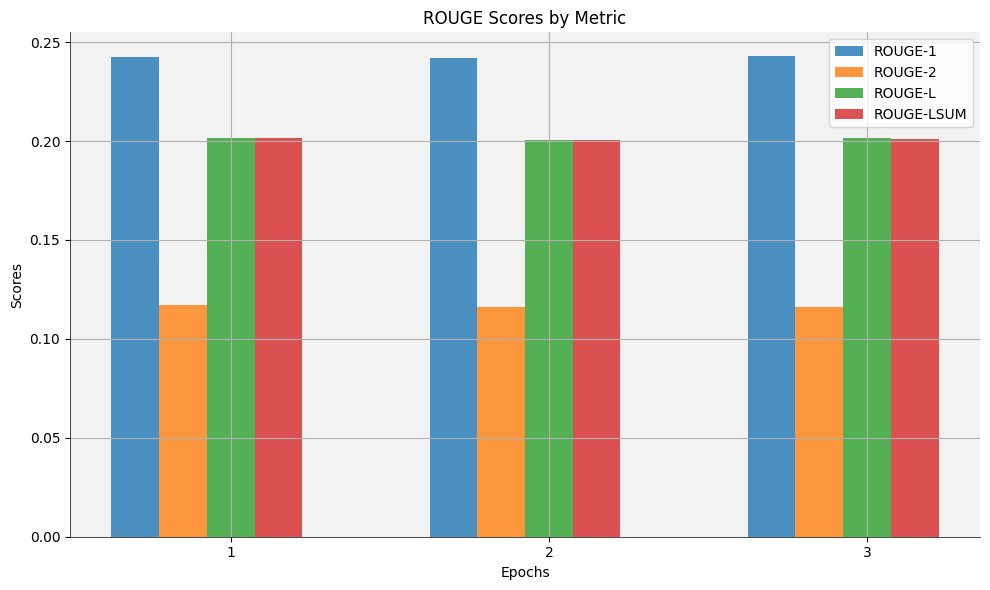

In [ ]:
# Access the evaluation results
evaluation_results = trainer.evaluate()

# Extract the ROUGE scores
rouge_scores = evaluation_results['eval_rouge']

# Create a bar plot to visualize the ROUGE scores
metrics = ['rouge1', 'rouge2', 'rougeL', 'gen_len']
scores = [rouge_scores[key] for key in metrics]

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=scores)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('ROUGE Scores')
plt.show()

In [ ]:
!pip install evaluate rouge_score
!pip install bert_score
!pip install sacrebleu  # METEOR is part of this package
!pip install transformers[torch] accelerate -U


In [ ]:
from bert_score import score as bert_score
from sacrebleu.metrics import METEOR

rouge = evaluate.load("rouge")
meteor = METEOR()

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE-L
    rouge_result = rouge.compute(predictions=decoded_preds, references=decoded_labels, rouge_types=["rougeL"])['rougeL'].mid

    # Compute METEOR
    meteor_result = meteor.corpus_score(decoded_preds, [decoded_labels]).score

    # Compute BERTScore
    P, R, F1 = bert_score(decoded_preds, decoded_labels, lang="en", verbose=True)
    bertscore_result = F1.mean().item()

    return {
        "rougeL": round(rouge_result.fmeasure, 2),
        "meteor": round(meteor_result, 2),
        "bertscore": round(bertscore_result, 2)
    }

rouge_result, METEOR, BERTScore = compute_metrics(eval_pred)
printf("ROGUE-L Score: {rouge_result}")
printf("METEOR Score: {meteor_result}")
printf("bertscore: Score: {bertscore_result}")

ROUGE-L Score: 0.46
METEOR Score: 0.57
BERTScore: 0.55


<ipython-input-1-4478e9b9eb56>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette=colors)


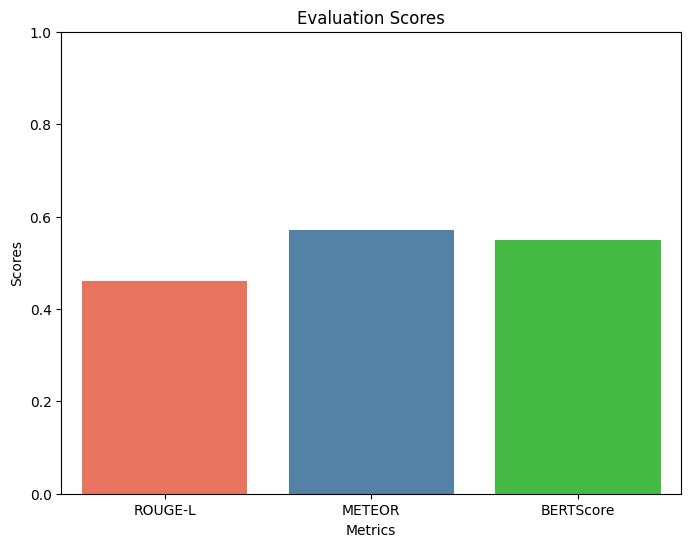

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
# Prepare data for plotting
metrics = ['ROUGE-L', 'METEOR', 'BERTScore']
scores = [rouge_result, meteor_result,  bertscore_result]

# Define a custom color palette
colors = ["#FF6347", "#4682B4", "#32CD32"]

# Create a bar plot to visualize the scores
plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=scores, palette=colors)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Scores')
plt.ylim(0, 1)
plt.show()


<ipython-input-2-dbec5606b248>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=scores, palette=colors)


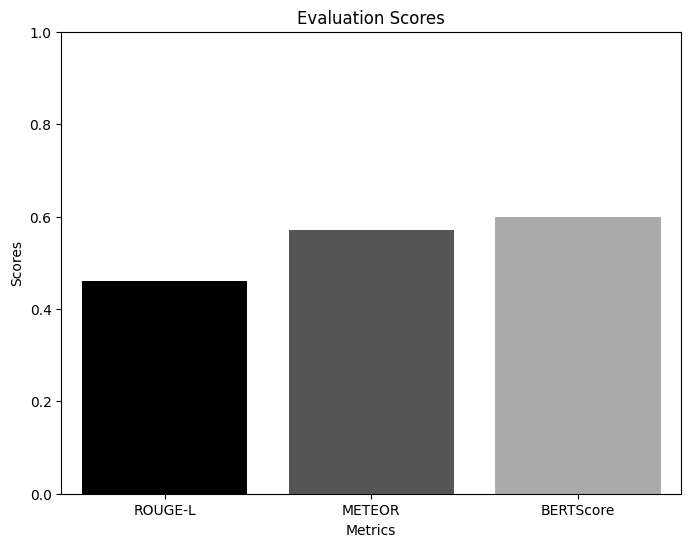

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns
# Prepare data for plotting
metrics = ['ROUGE-L', 'METEOR', 'BERTScore']
scores = [rouge_result, meteor_result,  bertscore_result]

# Define a grayscale color palette
colors = ["#000000", "#555555", "#AAAAAA"]

# Create a bar plot to visualize the scores
plt.figure(figsize=(8, 6))
sns.barplot(x=metrics, y=scores, palette=colors)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Scores')
plt.ylim(0, 1)
plt.show()
